In [1]:
import numpy as np
import matplotlib.pyplot as plt

from direct_lagrangian_simulation import LagrangianEquations

equations = LagrangianEquations(L=10, na=256, A=1e-6, h=4.0)

2020-06-15 22:28:17,639 pencil 0/1 INFO :: Building pencil matrix 1/128 (~1%) Elapsed: 0s, Remaining: 2s, Rate: 6.9e+01/s
2020-06-15 22:28:17,799 pencil 0/1 INFO :: Building pencil matrix 13/128 (~10%) Elapsed: 0s, Remaining: 2s, Rate: 7.5e+01/s
2020-06-15 22:28:17,979 pencil 0/1 INFO :: Building pencil matrix 26/128 (~20%) Elapsed: 0s, Remaining: 1s, Rate: 7.3e+01/s
2020-06-15 22:28:18,150 pencil 0/1 INFO :: Building pencil matrix 39/128 (~30%) Elapsed: 1s, Remaining: 1s, Rate: 7.4e+01/s
2020-06-15 22:28:18,320 pencil 0/1 INFO :: Building pencil matrix 52/128 (~41%) Elapsed: 1s, Remaining: 1s, Rate: 7.5e+01/s
2020-06-15 22:28:18,490 pencil 0/1 INFO :: Building pencil matrix 65/128 (~51%) Elapsed: 1s, Remaining: 1s, Rate: 7.5e+01/s
2020-06-15 22:28:18,658 pencil 0/1 INFO :: Building pencil matrix 78/128 (~61%) Elapsed: 1s, Remaining: 1s, Rate: 7.5e+01/s
2020-06-15 22:28:18,828 pencil 0/1 INFO :: Building pencil matrix 91/128 (~71%) Elapsed: 1s, Remaining: 0s, Rate: 7.6e+01/s
2020-06-15

iteration:  1000
time:  10.000000000000162


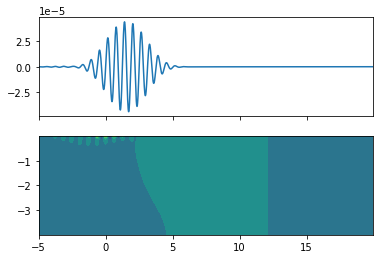

iteration:  2000
time:  20.00000000000047


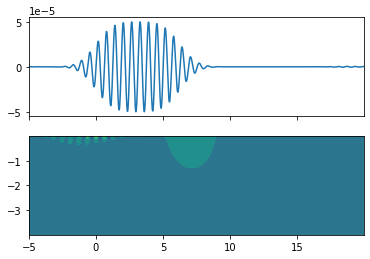

iteration:  3000
time:  30.00000000000078


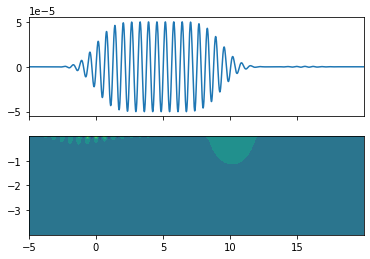

iteration:  4000
time:  39.9999999999983


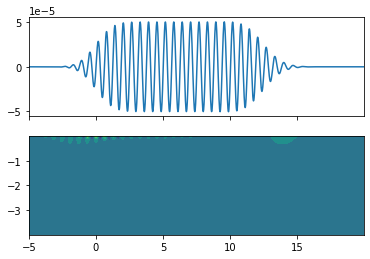

2020-06-15 22:30:40,457 solvers 0/1 INFO :: Stop iteration reached.


In [2]:
solver = equations.solver
domain = equations.domain
problem = equations.solver.problem

solver.stop_iteration = 4000
σ = solver.problem.parameters['σ']
dt = 0.01 * 2 * np.pi / σ

iters_per_period = 10 * int(np.round((2 * np.pi / σ) / dt))

scale = 10
a = domain.grid(0, scales=scale)
b = domain.grid(1, scales=scale)
A, B = np.meshgrid(a, b)

while solver.ok:
    solver.step(dt)

    if solver.iteration % iters_per_period == 0:
        print("iteration: ", solver.iteration)

        t = solver.sim_time

        print("time: ", σ * t / (2 * np.pi))

        solver.state['y'].set_scales(scale)
        solver.state['p'].set_scales(scale)

        y = solver.state['y']['g']
        p = solver.state['p']['g']
        η = y[:, -1]
        
        fig, axs = plt.subplots(nrows=2, sharex=True)

        plt.sca(axs[0])
        plt.plot(a, η)

        plt.sca(axs[1])
        plt.contourf(A, B, p.T)

        plt.pause(0.1)

In [3]:
equations.initialize_wave_mean_decomposition()
equations.wave_mean_decomposition()

/Users/gregorywagner/opt/anaconda3/envs/dedalus/lib/python3.8/site-packages/dedalus/core/distributor.py:334: ComplexWarning: Casting complex values to real discards the imaginary part
  gdata[:] = cdata[axslice(self.axis, 0, 1)]
/Users/gregorywagner/opt/anaconda3/envs/dedalus/lib/python3.8/site-packages/dedalus/core/distributor.py:334: ComplexWarning: Casting complex values to real discards the imaginary part
  gdata[:] = cdata[axslice(self.axis, 0, 1)]


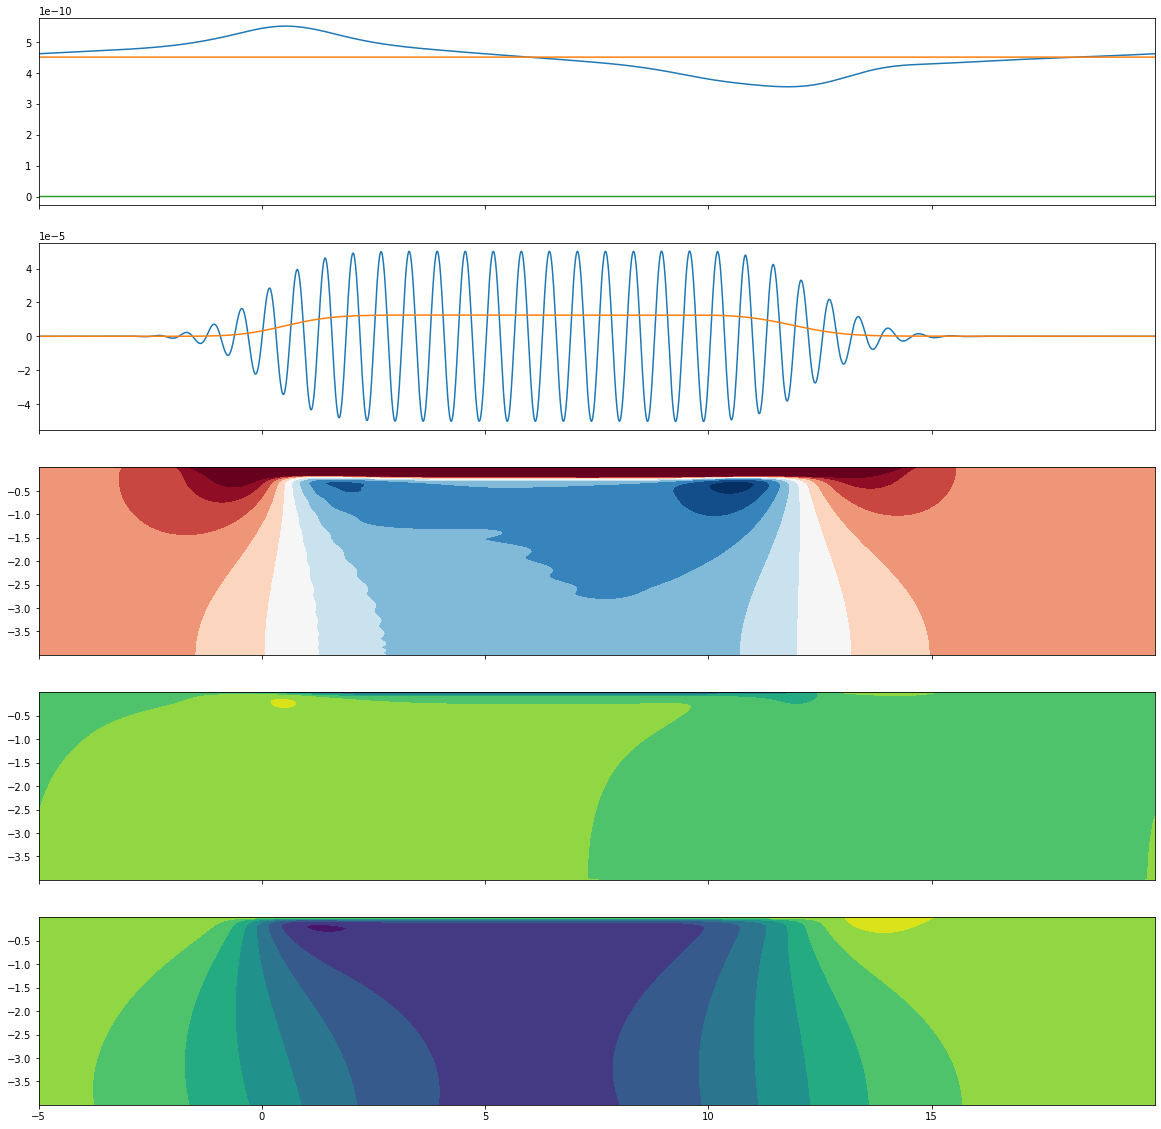

In [20]:
from dedalus import public as de

scale = 10
a = domain.grid(0, scales=scale)
b = domain.grid(1, scales=scale)
A, B = np.meshgrid(a, b)

h = np.max(b) - np.min(b)
L = np.max(a) - np.min(a)

U_op = de.operators.integrate(equations.mean_u, 'b')
U = U_op.evaluate()
U.set_scales(scale)

M_op = de.operators.integrate(equations.mean_u, 'a', 'b')
W_op = de.operators.integrate(equations.wave_u, 'a', 'b')
M = M_op.evaluate()
M.set_scales(scale)
W = W_op.evaluate()
W.set_scales(scale)

equations.u.set_scales(scale)
equations.y.set_scales(scale)
equations.mean_y.set_scales(scale)
equations.mean_u.set_scales(scale)
equations.mean_v.set_scales(scale)
equations.mean_p.set_scales(scale)

umax = np.max(np.abs(equations.mean_u['g']))
ulim = umax / 100
ulev = np.hstack((np.array([-umax]), np.linspace(-ulim, stop=ulim, num=10), np.array([umax])))

fig, axs = plt.subplots(nrows=5, figsize=(20, 20), sharex=True)

plt.sca(axs[0])
plt.plot(a, U['g'][:, 0] / h)
plt.plot(a, M['g'][:, 0] / (h * L))
plt.plot(a, W['g'][:, 0] / (h * L))

plt.sca(axs[1])
plt.plot(a, equations.y['g'][:, -1])
plt.plot(a, 1000 * equations.mean_y['g'][:, -1])

plt.sca(axs[2])
plt.contourf(A, B, equations.mean_u['g'].T, vmin=-ulim, vmax=ulim, cmap="RdBu_r", levels=ulev)
#plt.ylim(-1, 0)

plt.sca(axs[3])
plt.contourf(A, B, equations.mean_v['g'].T)

plt.sca(axs[4])
plt.contourf(A, B, equations.mean_p['g'].T)

plt.pause(0.1)